## Лабораторная работа №3. Feature engineering. Part 2.

### Задание.
***
**Цель лабораторной работы:** изучение продвинутых способов предварительной обработки данных для дальнейшего формирования моделей.

**Задание:**  
Для выбранного датасета (датасетов) на основе материалов лекций решить следующие задачи:
1. масштабирование признаков (не менее чем тремя способами);  
2. обработку выбросов для числовых признаков (по одному способу для удаления выбросов и для замены выбросов);  
3. обработку по крайней мере одного нестандартного признака (который не является числовым или категориальным);  
4. отбор признаков:  
  * один метод из группы методов фильтрации (filter methods);  
  * один метод из группы методов обертывания (wrapper methods);  
  * один метод из группы методов вложений (embedded methods).

### Выполнение.
***
Задание буду выполнять на датасете ["Computer Parts (CPUs and GPUs)"](https://www.kaggle.com/iliassekkaf/computerparts). Датасет содержит значения различных характеристик по CPU GPU. C данным датасетом я работал в ЛР2, а в данной ЛР я продолжу обрабатывать данный датасет, используя сохраненные наработки из ЛР2.

Загрузка и обзор датасета, сохраненного в конце ЛР2:

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from operator import itemgetter
import scipy.stats as stats
%matplotlib inline 
sns.set(style="ticks")

# Построение плотности распределения
def draw_kde(col_list, df1, df2, label1, label2):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
    # первый график
    ax1.set_title(label1)
    sns.kdeplot(data=df1[col_list], ax=ax1)
    # второй график
    ax2.set_title(label2)
    sns.kdeplot(data=df2[col_list], ax=ax2)
    plt.show()
    
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

dataset = pd.read_csv('../data/cpu-dataset-from-lr2.csv', sep=",")
dataset

,Product_Collection,Vertical_Segment,Status,Launch_Date,Lithography,nb_of_Cores,Processor_Base_Frequency,Cache,TDP,T,Intel_Hyper_Threading_Technology_,Intel_Virtualization_Technology_VTx_,Intel_64_,Instruction_Set,T_bc
0,13,2,927,49,1,2,1.30 GHz,65,4.5,100.0,1,2,1,1,4.605170
1,15,2,927,50,1,4,1.60 GHz,82,15.0,100.0,1,2,1,1,4.605170
2,16,2,927,50,1,4,1.80 GHz,87,15.0,100.0,1,2,1,1,4.605170
3,29,0,415,12,5,4,3.60 GHz,8,130.0,66.8,1,2,1,1,4.201703
4,12,2,927,17,1,2,1.20 GHz,65,4.5,100.0,1,2,1,1,4.605170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,10,2,927,48,1,2,1.10 GHz,65,4.5,100.0,1,2,1,1,4.605170
2054,10,2,927,48,1,2,1.10 GHz,65,4.5,100.0,1,2,1,1,4.605170
2055,10,2,927,48,1,2,1.20 GHz,65,4.5,100.0,1,2,1,1,4.605170
2056,6,2,927,15,1,2,2.00 GHz,65,15.0,105.0,1,2,1,1,4.653960


### Обработка одного нестандартного признака.  
***
Таким признаком (помимо Т, обработанного в ЛР2) является признак *Processor_Base_Frequency*. В датасете это не числовое значение (type `object`), но на деле представляет собой `float` значение. Причем частоты представлены в MHz и GHz, что также требует конвертации.  
Попробуем распрарсить числовые значения и привести их к одинаковой размерности - MHz.

In [2]:
dataset["Processor_Base_Frequency"].value_counts()

2.00 GHz    116
2.40 GHz    108
1.60 GHz    101
2.80 GHz     98
2.20 GHz     83
           ... 
1.91 GHz      1
930 MHz       1
2.17 GHz      1
333 MHz       1
1.75 GHz      1
Name: Processor_Base_Frequency, Length: 91, dtype: int64

In [3]:
regex_ghz = r"[0-9\.]*(?= GHz)"
regex_mhz = r"[0-9\.]*(?= MHz)"
col_name = "Processor_Base_Frequency"
for val in dataset[col_name]:
    if type(val) is not str:
        continue
    match = re.search(regex_ghz, str(val))
    if match:
        dataset[col_name] = dataset[col_name].replace([val], float(match.group()) * 1000)
    else:
        match = re.search(regex_mhz, str(val))
        if not match:        
            raise BaseException("Не удалось распарсить {}".format(val))
        else:
            dataset[col_name] = dataset[col_name].replace([val], float(match.group()))
dataset[col_name] = dataset[col_name].astype(int)

In [4]:
dataset["Processor_Base_Frequency"].value_counts()

2000    116
2400    108
1600    101
2800     98
2200     83
       ... 
433       1
1750      1
2170      1
333       1
1910      1
Name: Processor_Base_Frequency, Length: 91, dtype: int64

### Масштабирование признаков.  
***
Выделим признаки, которые необходимо масштабировать:

In [5]:
dataset_num = dataset[["nb_of_Cores", "Processor_Base_Frequency", "T", "T_bc", "TDP"]]

In [6]:
dataset_num

,nb_of_Cores,Processor_Base_Frequency,T,T_bc,TDP
0,2,1300,100.0,4.605170,4.5
1,4,1600,100.0,4.605170,15.0
2,4,1800,100.0,4.605170,15.0
3,4,3600,66.8,4.201703,130.0
4,2,1200,100.0,4.605170,4.5
...,...,...,...,...,...
2053,2,1100,100.0,4.605170,4.5
2054,2,1100,100.0,4.605170,4.5
2055,2,1200,100.0,4.605170,4.5
2056,2,2000,105.0,4.653960,15.0


Масштабирование данных на основе Z-оценки (используем `StandardScaler`):

In [7]:
standard_scaler = StandardScaler()
dataset_num_ss = pd.DataFrame(standard_scaler.fit_transform(dataset_num), columns=dataset_num.columns)
dataset_num_ss.describe()

,nb_of_Cores,Processor_Base_Frequency,T,T_bc,TDP
count,2.058000e+03,2.058000e+03,2.058000e+03,2.058000e+03,2.058000e+03
mean,1.009127e-15,-2.717835e-16,-2.123342e-16,4.455997e-16,-4.857361e-16
std,1.000243e+00,1.000243e+00,1.000243e+00,1.000243e+00,1.000243e+00
min,-5.097813e-01,-2.557890e+00,-2.142569e+00,-2.503936e+00,-1.400169e+00
25%,-3.143762e-01,-7.507757e-01,-9.487338e-01,-9.123622e-01,-8.023500e-01
50%,-3.143762e-01,9.945685e-03,2.385053e-01,3.142552e-01,-2.622255e-01
75%,7.643397e-02,7.802964e-01,8.980825e-01,8.934207e-01,6.461655e-01
max,1.336398e+01,2.577781e+00,1.557660e+00,1.417340e+00,4.967161e+00


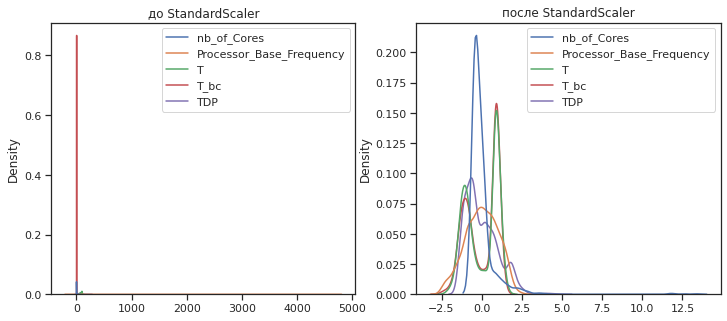

In [8]:
draw_kde(dataset_num.columns, dataset_num, dataset_num_ss, "до StandardScaler", "после StandardScaler")

MinMax-масштабирование данных (используем `MinMaxScaler`):

In [9]:
min_max_scaler = MinMaxScaler()
dataset_num_mm = pd.DataFrame(min_max_scaler.fit_transform(dataset_num), columns=dataset_num.columns)
dataset_num_mm.describe()

,nb_of_Cores,Processor_Base_Frequency,T,T_bc,TDP
count,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000
mean,0.036744,0.498063,0.579037,0.638551,0.219899
std,0.072096,0.194764,0.270319,0.255081,0.157090
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.014085,0.351875,0.322638,0.405882,0.093889
50%,0.014085,0.500000,0.643494,0.718692,0.178716
75%,0.042254,0.650000,0.821747,0.866391,0.321380
max,1.000000,1.000000,1.000000,1.000000,1.000000


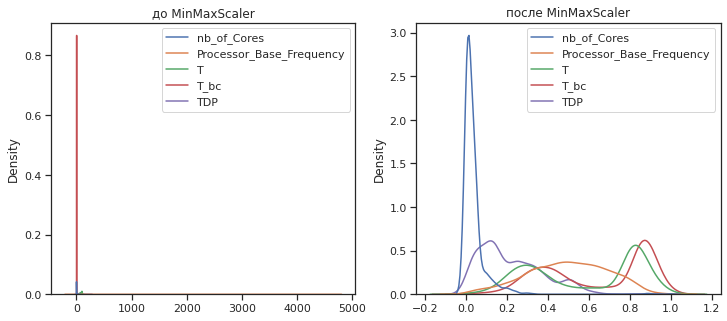

In [10]:
draw_kde(dataset_num.columns, dataset_num, dataset_num_mm, "до MinMaxScaler", "после MinMaxScaler")

Масштабирование по медиане (используем `RobustScaler`):

In [11]:
robust_scaler = RobustScaler()
dataset_num_r = pd.DataFrame(robust_scaler.fit_transform(dataset_num), columns=dataset_num.columns)
dataset_num_r.describe()

,nb_of_Cores,Processor_Base_Frequency,T,T_bc,TDP
count,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000
mean,0.804422,-0.006496,-0.129144,-0.174027,0.181031
std,2.559409,0.653296,0.541604,0.553911,0.690530
min,-0.500000,-1.677149,-1.289286,-1.560648,-0.785593
25%,0.000000,-0.496855,-0.642857,-0.679272,-0.372881
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.503145,0.357143,0.320728,0.627119
max,35.000000,1.677149,0.714286,0.610862,3.610169


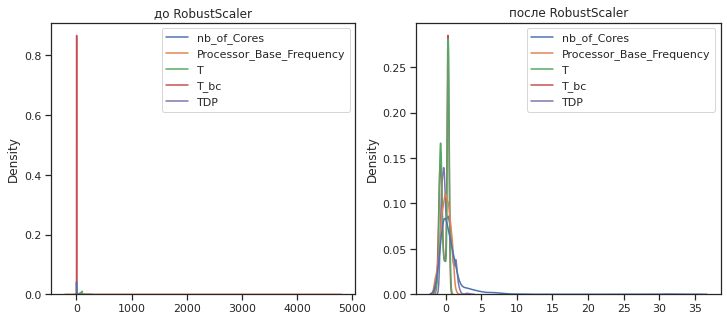

In [12]:
draw_kde(dataset_num.columns, dataset_num, dataset_num_r, "до RobustScaler", "после RobustScaler")

Заменим в оригинальном датасете масштабированные признаки

### Обработка выбросов
***

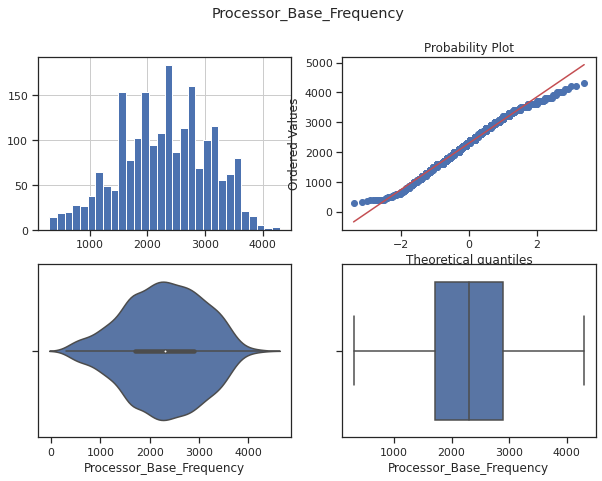

In [13]:
col_with_outlier = "Processor_Base_Frequency"
diagnostic_plots(dataset, "Processor_Base_Frequency", "Processor_Base_Frequency")

Как видим распределение признака `Processor_Base_Frequency` нормальное, таким образом выборсы можно определять по правилу трех сигм или 5% и 95% квантилей. Воспользуемся последним правилом.  
Устраним выбросы с помощью *удаления выбросов*:

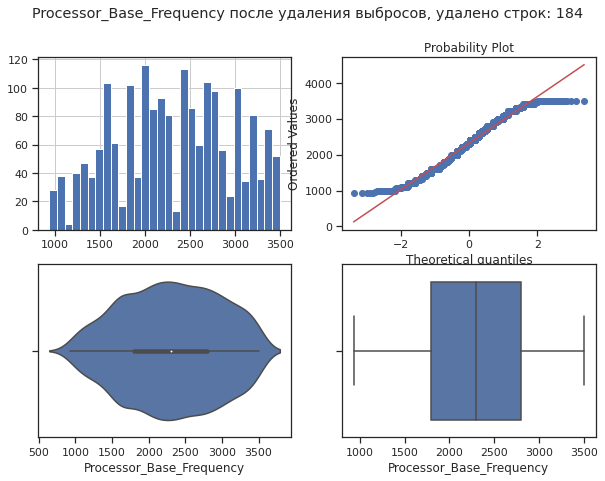

In [14]:
lower_boundary = dataset[col_with_outlier].quantile(0.05)
upper_boundary = dataset[col_with_outlier].quantile(0.95)
outliers_temp = np.where(dataset[col_with_outlier] > upper_boundary, True, 
                         np.where(dataset[col_with_outlier] < lower_boundary, True, False))
# Удаление данных на основе флага
dataset_trimmed = dataset.loc[~(outliers_temp), ]  
title = "Processor_Base_Frequency после удаления выбросов, удалено строк: {}".format(dataset.shape[0] - dataset_trimmed.shape[0])
diagnostic_plots(dataset_trimmed, col_with_outlier, title)

Устраним выбросы с помощью *замены выбросов* на найденные верхнюю и нижнюю границы:

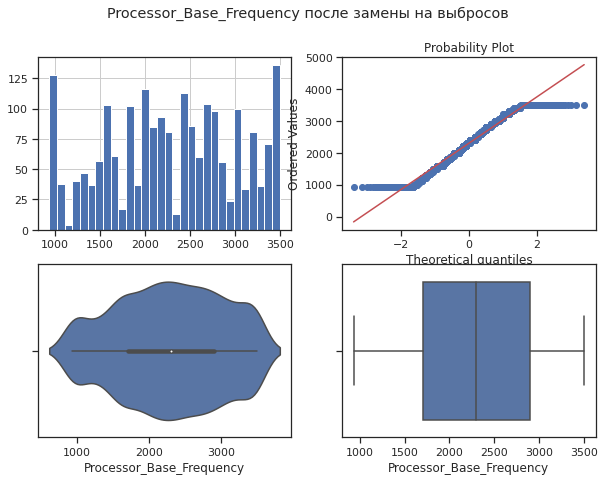

In [15]:
dataset_replaced = dataset
dataset_replaced[col_with_outlier] = np.where(dataset[col_with_outlier] > upper_boundary, upper_boundary, 
                                     np.where(dataset[col_with_outlier] < lower_boundary, lower_boundary, dataset[col_with_outlier]))
diagnostic_plots(dataset_replaced, col_with_outlier, "Processor_Base_Frequency после замены на выбросов")

Перед отбором признаков, отмасштабируем их используя min max scaler:

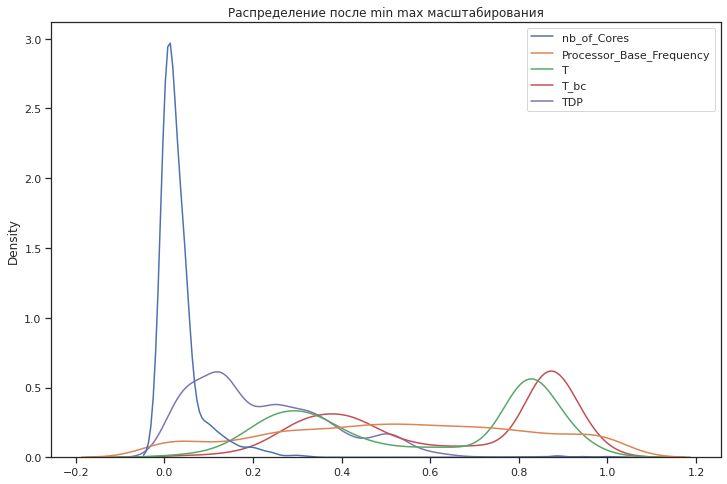

In [16]:
x_names = ["nb_of_Cores", "Processor_Base_Frequency", "T", "T_bc", "TDP"]
y_name = "Product_Collection"
min_max_scaler_2 = MinMaxScaler()
dataset_tmp = pd.DataFrame(min_max_scaler_2.fit_transform(dataset[x_names]), columns=x_names)
dataset_tmp[y_name] = dataset[y_name].astype(int)
dataset = dataset_tmp
_, ax = plt.subplots(figsize = (12,8))
ax.set_title("Распределение после min max масштабирования")
sns.kdeplot(data=dataset[x_names], ax=ax)
plt.show()

### Отбор признаков
***
Выберем признаки, наиболее полезные для дальнейшего построения модели.  
1. Filter methods. Воспользуемся матрицей корреляции для определения признаков которые стоит исключить.

<AxesSubplot:>

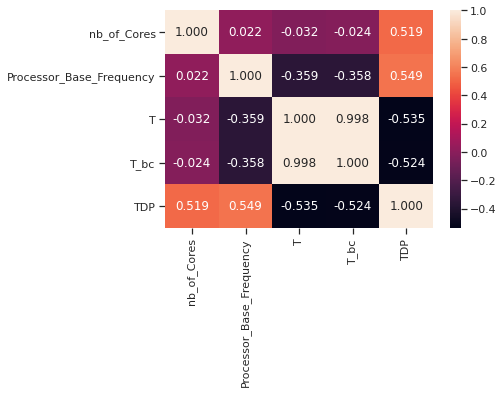

In [17]:
sns.heatmap(dataset[x_names].corr(), annot=True, fmt='.3f')

Видно что признаки T_bc и T коррелируют друг сдругом и ни один из них не является целевым.  
Стоит исключить один из них.  
2. Методы обертывания (wrapper methods). Алгоритм полного перебора.

In [18]:
knn = KNeighborsClassifier(n_neighbors=4)
efs1 = EFS(knn, 
           min_features=1,
           max_features=5,
           scoring='accuracy',
           print_progress=True, cv=2)

efs1 = efs1.fit(dataset[x_names], dataset[y_name])

print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

Features: 31/31

Best accuracy score: 0.33
Best subset (corresponding names): ('nb_of_Cores', 'T', 'TDP')


3. Методы вложений (embedded methods)

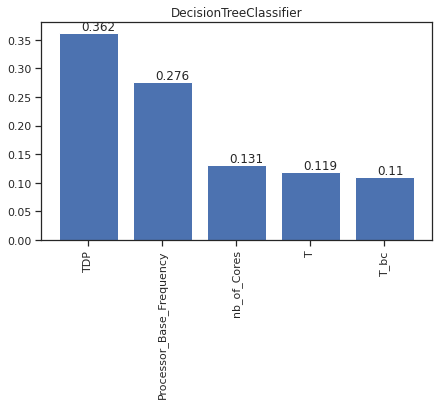

In [19]:
def draw_feature_importances(tree_model, X_dataset, title, figsize=(7,4)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.1, b+0.005, str(round(b,3)))
    plt.show()
    return labels, data

decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(dataset[x_names], dataset[y_name])
_,_ = draw_feature_importances(decision_tree_classifier, dataset[x_names], "DecisionTreeClassifier")